In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.api import models
from keras.api import layers

data_dir = '/mnt/data/datasets/nlp_disaster_tweets'


In [2]:
def plot_training_history(history):
    """
    Plot the training and validation loss and accuracy against the number of epochs.
    Parameters:
    - history: History object returned by the fit method of a Keras model
    """
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()
    

def train_model(model, model_name, X, y, epochs=100, batch_size=32, validation_split=0.2,
                optimizer='Adam', loss='binary_crossentropy',
                plot_history=True):
    """
    Trains a Keras model with the given data and saves the best weights based on validation AUC.
    Stops early if there is no improvement in validation AUC for 10 epochs.
    Using validation AUC for calculating best weights as this is the scoring critieria
    for the kaggle competition.
    Parameters:
    - model: Keras model to train.
    - model_name: String, name of the model used for naming the weights file.
    - X: Training data.
    - y: Training labels.
    - epochs: Integer, number of epochs to train.
    - batch_size: Integer, batch size for training.
    - validation_split: Float, fraction of data to use for validation.
    - optimizer: Keras optimizer.
    - loss: Keras loss function.
    - plot_history: Boolean, whether to plot the training history.
    Returns:
    - Trained Keras model with the best weights loaded.
    """
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', 'F1Score'])
    checkpointer = keras.callbacks.ModelCheckpoint(
        f'{model_name}.best_weights.keras', 
        save_best_only=True,
        verbose=1)
    early_stopping = keras.callbacks.EarlyStopping(
        patience=4,
        verbose=1)

    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, 
                        callbacks=[checkpointer, early_stopping])
    
    if plot_history:
        plot_training_history(history)

    model.load_weights(f'{model_name}.best_weights.keras')
    return model # , history

 
def evaluate_model_and_print_results(model, X_test, y_test):
    """
    Evaluates the model on the test data and prints the results.
    Parameters:
    - model: Keras model to evaluate.
    - X_test: Test data.
    - y_test: Test labels.
    """
    test_loss, test_accuracy, test_f1score = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_accuracy}')
    print(f'Test F1 Score: {test_f1score}')

In [27]:
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(data_dir, 'test.csv'))
submission_df = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))


In [28]:
print(train_df.head())
train_df.info()

   id keyword  ...                                               text target
0   1     NaN  ...  Our Deeds are the Reason of this #earthquake M...      1
1   4     NaN  ...             Forest fire near La Ronge Sask. Canada      1
2   5     NaN  ...  All residents asked to 'shelter in place' are ...      1
3   6     NaN  ...  13,000 people receive #wildfires evacuation or...      1
4   7     NaN  ...  Just got sent this photo from Ruby #Alaska as ...      1

[5 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


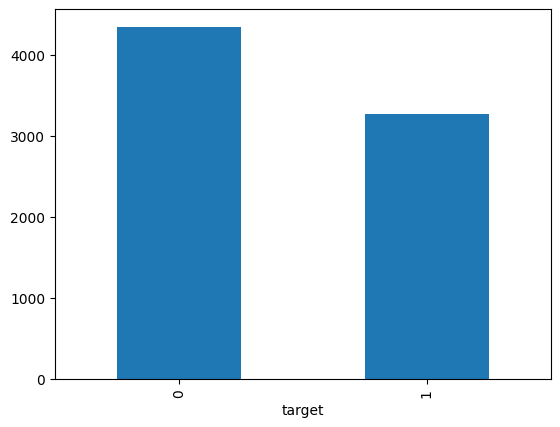

In [29]:
train_df['target'].value_counts().plot(kind='bar')
plt.show()

In [30]:
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from wordcloud import WordCloud
import re

# TODO: Filter out URLs
# TODO: Filter out non-english text
def clean_text(text):
    text = text.lower()
    # Remove urls from text
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove html escape characters
    text = re.sub(r'&amp;', 'and', text)
    text = re.sub(r'&lt;', '<', text)
    text = re.sub(r'&gt;', '>', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    # Remove non-english characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    text = ' '.join([word for word in text.split() 
                     if word not in ENGLISH_STOP_WORDS 
                     if word not in ['s', 're', 'm', 've', 't', 'new', 'people']])
    return text



In [31]:
train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

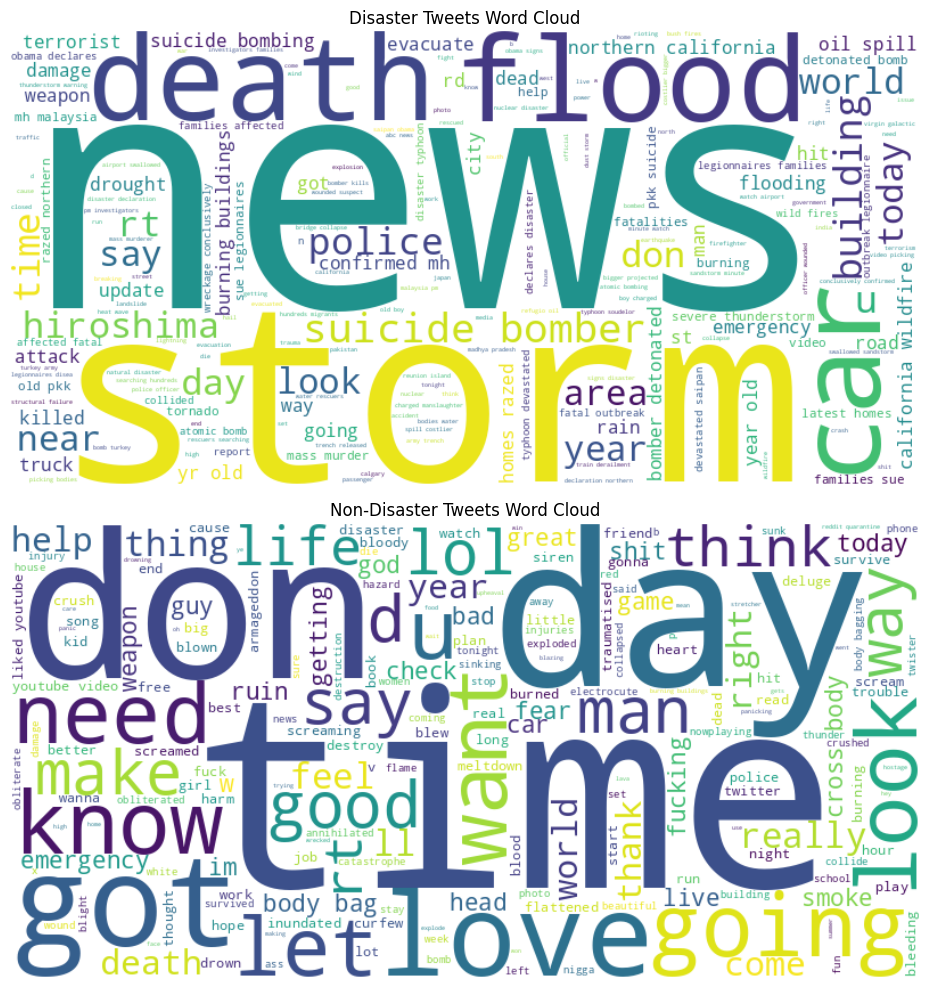

In [32]:
disaster_text = ' '.join(train_df[train_df['target'] == 1]['text'])
non_disaster_text = ' '.join(train_df[train_df['target'] == 0]['text'])

disaster_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(disaster_text)
non_disaster_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(non_disaster_text)

# Plotting wordclouds for disaster tweets and non-disaster tweets in training data
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].imshow(disaster_wordcloud, interpolation='bilinear')
ax[0].axis('off')
ax[0].set_title('Disaster Tweets Word Cloud')
ax[1].imshow(non_disaster_wordcloud, interpolation='bilinear')
ax[1].axis('off')
ax[1].set_title('Non-Disaster Tweets Word Cloud')
plt.tight_layout()
plt.show()

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=2000, max_df=0.8)

X_train_tfidf = tfidf.fit_transform(train_df['text'])
X_test_tfidf = tfidf.transform(test_df['text'])

Y_train = train_df['target']

print(X_train_tfidf.shape)
print(X_test_tfidf.shape)
print(Y_train.shape)

(7613, 2000)
(3263, 2000)
(7613,)


In [34]:
model = models.Sequential([
    layers.Input(shape=(X_train_tfidf.shape[1],)),
    layers.Embedding(input_dim=X_train_tfidf.shape[1], output_dim=128),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

2025-06-07 13:30:22.950976: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 2000, 128)      │       256,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 2000, 256)      │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 691,841 (2.64 MB)

 Trainable params: 691,841 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model = train_model(model, 'lstm_model', X_train_tfidf, Y_train,
                    epochs=10, batch_size=64)

Epoch 1/10
 7/96 ━━━━━━━━━━━━━━━━━━━━ 8:24 6s/step - F1Score: 0.5600 - accuracy: 0.6107 - loss: 0.6911

KeyboardInterrupt: 